***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- Applying bottom-up approach. (Fine-to-Coarse)
- Changing the Secondary Capsule Dimension:
    - 16D>12D>8D (Fine>Medium>Coarse)
    - Use Hinge Loss (MarginLoss) for each level + Consistency Loss.
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('MOD_1/3_CIFAR_10/HD_CapsNet/BU_W_C_loss')

FOLDER CREATED =  ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/BU_W_C_loss


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=7)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=10)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 12
    SCap_c_dims = 8


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 10)          0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 10)          0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.2622 - prediction_coarse_accuracy: 0.8431 - prediction_medium_accuracy: 0.5555 - prediction_fine_accuracy: 0.4716
  • Coarse Accuracy = 84.31% | Val_Accuracy = 93.54% | LossWeight = 0.21 
  • Medium Accuracy = 55.55% | Val_Accuracy = 71.48% | LossWeight = 0.42 
  • Fine   Accuracy = 47.16% | Val_Accuracy = 61.35% | LossWeight = 0.37 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.61350, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/BU_W_C_loss\epoch-best.h5
781/781 [==============================] - 57s 63ms/step - loss: 0.2622 - prediction_coarse_accuracy: 0.8431 - prediction_medium_accuracy: 0.5555 - prediction_fine_accuracy: 0.4716 - val_loss: 0.1267 - val_prediction_coarse_accuracy: 0.9354 - val_prediction_medium_accuracy: 0.7148 - val_prediction_fine_accuracy: 0.6135 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1235 - prediction_coarse_accuracy

781/781 [==============================] - 47s 60ms/step - loss: 0.0674 - prediction_coarse_accuracy: 0.9711 - prediction_medium_accuracy: 0.9064 - prediction_fine_accuracy: 0.8698 - val_loss: 0.0472 - val_prediction_coarse_accuracy: 0.9701 - val_prediction_medium_accuracy: 0.8862 - val_prediction_fine_accuracy: 0.8441 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.0653 - prediction_coarse_accuracy: 0.9702 - prediction_medium_accuracy: 0.9097 - prediction_fine_accuracy: 0.8756
  • Coarse Accuracy = 97.02% | Val_Accuracy = 97.44% | LossWeight = 0.19 
  • Medium Accuracy = 90.97% | Val_Accuracy = 89.64% | LossWeight = 0.40 
  • Fine   Accuracy = 87.56% | Val_Accuracy = 86.07% | LossWeight = 0.41 

Epoch 10: val_prediction_fine_accuracy improved from 0.84470 to 0.86070, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/BU_W_C_loss\epoch-best.h5
781/781 [==============================] - 47s 61ms/step - loss: 0.0653 - prediction_coarse_accuracy:

Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0518 - prediction_coarse_accuracy: 0.9807 - prediction_medium_accuracy: 0.9499 - prediction_fine_accuracy: 0.9316
  • Coarse Accuracy = 98.07% | Val_Accuracy = 98.33% | LossWeight = 0.21 
  • Medium Accuracy = 94.99% | Val_Accuracy = 92.33% | LossWeight = 0.39 
  • Fine   Accuracy = 93.16% | Val_Accuracy = 88.98% | LossWeight = 0.40 

Epoch 19: val_prediction_fine_accuracy improved from 0.88000 to 0.88980, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/BU_W_C_loss\epoch-best.h5
781/781 [==============================] - 48s 61ms/step - loss: 0.0518 - prediction_coarse_accuracy: 0.9807 - prediction_medium_accuracy: 0.9499 - prediction_fine_accuracy: 0.9316 - val_loss: 0.0339 - val_prediction_coarse_accuracy: 0.9833 - val_prediction_medium_accuracy: 0.9233 - val_prediction_fine_accuracy: 0.8898 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0516 - prediction_coars

781/781 [==============================] - ETA: 0s - loss: 0.0481 - prediction_coarse_accuracy: 0.9828 - prediction_medium_accuracy: 0.9605 - prediction_fine_accuracy: 0.9499
  • Coarse Accuracy = 98.28% | Val_Accuracy = 98.47% | LossWeight = 0.24 
  • Medium Accuracy = 96.05% | Val_Accuracy = 93.06% | LossWeight = 0.39 
  • Fine   Accuracy = 94.99% | Val_Accuracy = 90.07% | LossWeight = 0.37 

Epoch 28: val_prediction_fine_accuracy improved from 0.89790 to 0.90070, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/BU_W_C_loss\epoch-best.h5
781/781 [==============================] - 47s 61ms/step - loss: 0.0481 - prediction_coarse_accuracy: 0.9828 - prediction_medium_accuracy: 0.9605 - prediction_fine_accuracy: 0.9499 - val_loss: 0.0310 - val_prediction_coarse_accuracy: 0.9847 - val_prediction_medium_accuracy: 0.9306 - val_prediction_fine_accuracy: 0.9007 - lr: 3.9721e-04
Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.0481 - prediction_coarse_accuracy: 0

781/781 [==============================] - 47s 60ms/step - loss: 0.0469 - prediction_coarse_accuracy: 0.9839 - prediction_medium_accuracy: 0.9636 - prediction_fine_accuracy: 0.9567 - val_loss: 0.0303 - val_prediction_coarse_accuracy: 0.9868 - val_prediction_medium_accuracy: 0.9300 - val_prediction_fine_accuracy: 0.8999 - lr: 2.5034e-04
Epoch 38/100
781/781 [==============================] - ETA: 0s - loss: 0.0465 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9643 - prediction_fine_accuracy: 0.9578
  • Coarse Accuracy = 98.48% | Val_Accuracy = 98.59% | LossWeight = 0.24 
  • Medium Accuracy = 96.43% | Val_Accuracy = 93.38% | LossWeight = 0.40 
  • Fine   Accuracy = 95.78% | Val_Accuracy = 90.47% | LossWeight = 0.36 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.90500
781/781 [==============================] - 47s 60ms/step - loss: 0.0465 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9643 - prediction_fine_accuracy: 0.9578 - 

Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0462 - prediction_coarse_accuracy: 0.9846 - prediction_medium_accuracy: 0.9653 - prediction_fine_accuracy: 0.9595
  • Coarse Accuracy = 98.46% | Val_Accuracy = 98.69% | LossWeight = 0.25 
  • Medium Accuracy = 96.53% | Val_Accuracy = 93.49% | LossWeight = 0.40 
  • Fine   Accuracy = 95.95% | Val_Accuracy = 90.83% | LossWeight = 0.35 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.90980
781/781 [==============================] - 47s 60ms/step - loss: 0.0462 - prediction_coarse_accuracy: 0.9846 - prediction_medium_accuracy: 0.9653 - prediction_fine_accuracy: 0.9595 - val_loss: 0.0287 - val_prediction_coarse_accuracy: 0.9869 - val_prediction_medium_accuracy: 0.9349 - val_prediction_fine_accuracy: 0.9083 - lr: 1.4989e-04
Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0457 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9669 - prediction_fine_accuracy: 0.

781/781 [==============================] - 48s 61ms/step - loss: 0.0455 - prediction_coarse_accuracy: 0.9851 - prediction_medium_accuracy: 0.9670 - prediction_fine_accuracy: 0.9619 - val_loss: 0.0276 - val_prediction_coarse_accuracy: 0.9865 - val_prediction_medium_accuracy: 0.9375 - val_prediction_fine_accuracy: 0.9118 - lr: 9.4468e-05
Epoch 57/100
781/781 [==============================] - ETA: 0s - loss: 0.0450 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9666 - prediction_fine_accuracy: 0.9610
  • Coarse Accuracy = 98.44% | Val_Accuracy = 98.70% | LossWeight = 0.26 
  • Medium Accuracy = 96.66% | Val_Accuracy = 93.71% | LossWeight = 0.39 
  • Fine   Accuracy = 96.10% | Val_Accuracy = 91.12% | LossWeight = 0.34 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.91180
781/781 [==============================] - 47s 60ms/step - loss: 0.0450 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9666 - prediction_fine_accuracy: 0.9610 - 

Epoch 66/100
781/781 [==============================] - ETA: 0s - loss: 0.0455 - prediction_coarse_accuracy: 0.9854 - prediction_medium_accuracy: 0.9671 - prediction_fine_accuracy: 0.9621
  • Coarse Accuracy = 98.54% | Val_Accuracy = 98.72% | LossWeight = 0.25 
  • Medium Accuracy = 96.71% | Val_Accuracy = 93.81% | LossWeight = 0.40 
  • Fine   Accuracy = 96.21% | Val_Accuracy = 91.11% | LossWeight = 0.35 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.91260
781/781 [==============================] - 50s 64ms/step - loss: 0.0455 - prediction_coarse_accuracy: 0.9854 - prediction_medium_accuracy: 0.9671 - prediction_fine_accuracy: 0.9621 - val_loss: 0.0275 - val_prediction_coarse_accuracy: 0.9872 - val_prediction_medium_accuracy: 0.9381 - val_prediction_fine_accuracy: 0.9111 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0449 - prediction_coarse_accuracy: 0.9849 - prediction_medium_accuracy: 0.9665 - prediction_fine_accuracy: 0.

781/781 [==============================] - 50s 64ms/step - loss: 0.0451 - prediction_coarse_accuracy: 0.9857 - prediction_medium_accuracy: 0.9680 - prediction_fine_accuracy: 0.9634 - val_loss: 0.0271 - val_prediction_coarse_accuracy: 0.9867 - val_prediction_medium_accuracy: 0.9390 - val_prediction_fine_accuracy: 0.9121 - lr: 3.5648e-05
Epoch 76/100
781/781 [==============================] - ETA: 0s - loss: 0.0450 - prediction_coarse_accuracy: 0.9854 - prediction_medium_accuracy: 0.9673 - prediction_fine_accuracy: 0.9622
  • Coarse Accuracy = 98.54% | Val_Accuracy = 98.62% | LossWeight = 0.25 
  • Medium Accuracy = 96.73% | Val_Accuracy = 93.74% | LossWeight = 0.40 
  • Fine   Accuracy = 96.22% | Val_Accuracy = 91.15% | LossWeight = 0.35 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.91320
781/781 [==============================] - 50s 64ms/step - loss: 0.0450 - prediction_coarse_accuracy: 0.9854 - prediction_medium_accuracy: 0.9673 - prediction_fine_accuracy: 0.9622 - 

781/781 [==============================] - ETA: 0s - loss: 0.0446 - prediction_coarse_accuracy: 0.9855 - prediction_medium_accuracy: 0.9683 - prediction_fine_accuracy: 0.9633
  • Coarse Accuracy = 98.55% | Val_Accuracy = 98.76% | LossWeight = 0.26 
  • Medium Accuracy = 96.83% | Val_Accuracy = 93.94% | LossWeight = 0.40 
  • Fine   Accuracy = 96.33% | Val_Accuracy = 91.27% | LossWeight = 0.34 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.91320
781/781 [==============================] - 49s 63ms/step - loss: 0.0446 - prediction_coarse_accuracy: 0.9855 - prediction_medium_accuracy: 0.9683 - prediction_fine_accuracy: 0.9633 - val_loss: 0.0268 - val_prediction_coarse_accuracy: 0.9876 - val_prediction_medium_accuracy: 0.9394 - val_prediction_fine_accuracy: 0.9127 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0446 - prediction_coarse_accuracy: 0.9855 - prediction_medium_accuracy: 0.9694 - prediction_fine_accuracy: 0.9649
  • Coar

781/781 [==============================] - 49s 62ms/step - loss: 0.0451 - prediction_coarse_accuracy: 0.9860 - prediction_medium_accuracy: 0.9692 - prediction_fine_accuracy: 0.9645 - val_loss: 0.0268 - val_prediction_coarse_accuracy: 0.9876 - val_prediction_medium_accuracy: 0.9378 - val_prediction_fine_accuracy: 0.9121 - lr: 1.3452e-05
Epoch 95/100
781/781 [==============================] - ETA: 0s - loss: 0.0446 - prediction_coarse_accuracy: 0.9853 - prediction_medium_accuracy: 0.9682 - prediction_fine_accuracy: 0.9642
  • Coarse Accuracy = 98.53% | Val_Accuracy = 98.74% | LossWeight = 0.26 
  • Medium Accuracy = 96.82% | Val_Accuracy = 93.90% | LossWeight = 0.40 
  • Fine   Accuracy = 96.42% | Val_Accuracy = 91.25% | LossWeight = 0.34 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.91320
781/781 [==============================] - 49s 63ms/step - loss: 0.0446 - prediction_coarse_accuracy: 0.9853 - prediction_medium_accuracy: 0.9682 - prediction_fine_accuracy: 0.9642 - 

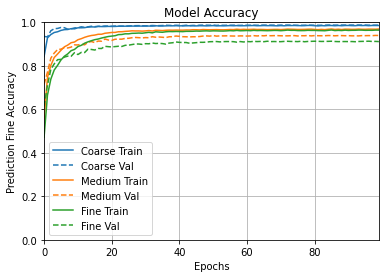

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

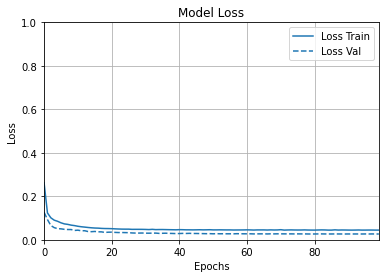

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 17ms/step - loss: 0.0428 - prediction_coarse_loss: 0.0102 - prediction_medium_loss: 0.0452 - prediction_fine_loss: 0.0651 - prediction_coarse_accuracy: 0.9871 - prediction_medium_accuracy: 0.9396 - prediction_fine_accuracy: 0.9116
1. loss ==> 0.04282010346651077
2. prediction_coarse_loss ==> 0.010240387171506882
3. prediction_medium_loss ==> 0.045225292444229126
4. prediction_fine_loss ==> 0.06505919992923737
5. prediction_coarse_accuracy ==> 0.9871000051498413
6. prediction_medium_accuracy ==> 0.9395999908447266
7. prediction_fine_accuracy ==> 0.9115999937057495
313/313 [==============================] - 4s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

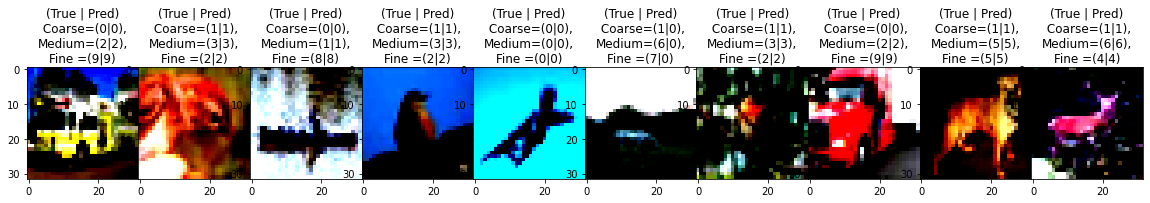

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3950   50]
 [  79 5921]]

  • MEDIUM LEVEL 
[[ 943   17   14   12    1    9    4]
 [  22  950   20    3    1    3    1]
 [   9   13 1968    1    4    4    1]
 [  28    2    4  865   22   48   31]
 [   6    4    4   14  945   22    5]
 [  12    6   11   39   37 1841   54]
 [   8    2    4   30   20   52 1884]]

  • FINE LEVEL 
[[945   4  12   5   2   2   1   2  17  10]
 [  3 967   2   0   1   0   1   0   6  20]
 [ 29   2 866  29  17  21  21  11   2   2]
 [  9   2  28 803  16  88  30  10   8   6]
 [  6   1  22  23 900   8  22  17   1   0]
 [  5   1  15  89  18 852   7  12   0   1]
 [  6   2  14  22   4   3 942   1   5   1]
 [  4   0  11  10  18  10   1 945   0   1]
 [ 24   5   3   3   0   0   1   1 952  11]
 [  8  31   1   3   0   1   3   1   8 944]]

  • Classification Report 


  • COARSE LEVEL 


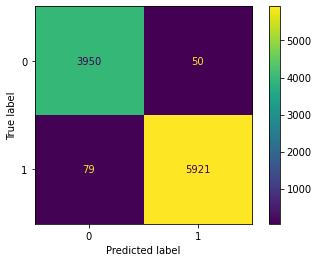

              precision    recall  f1-score   support

           0    0.98039   0.98750   0.98393      4000
           1    0.99163   0.98683   0.98922      6000

    accuracy                        0.98710     10000
   macro avg    0.98601   0.98717   0.98658     10000
weighted avg    0.98713   0.98710   0.98711     10000


  • MEDIUM LEVEL 


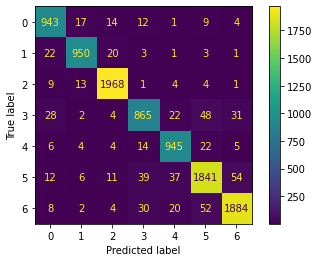

              precision    recall  f1-score   support

           0    0.91732   0.94300   0.92998      1000
           1    0.95573   0.95000   0.95286      1000
           2    0.97185   0.98400   0.97789      2000
           3    0.89730   0.86500   0.88086      1000
           4    0.91748   0.94500   0.93103      1000
           5    0.93027   0.92050   0.92536      2000
           6    0.95152   0.94200   0.94673      2000

    accuracy                        0.93960     10000
   macro avg    0.93449   0.93564   0.93496     10000
weighted avg    0.93951   0.93960   0.93947     10000


  • FINE LEVEL 


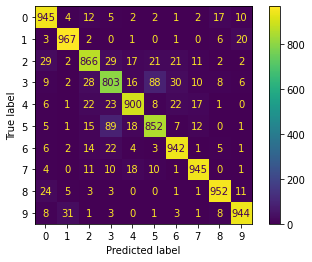

              precision    recall  f1-score   support

           0    0.90953   0.94500   0.92692      1000
           1    0.95271   0.96700   0.95980      1000
           2    0.88912   0.86600   0.87741      1000
           3    0.81358   0.80300   0.80825      1000
           4    0.92213   0.90000   0.91093      1000
           5    0.86497   0.85200   0.85844      1000
           6    0.91545   0.94200   0.92854      1000
           7    0.94500   0.94500   0.94500      1000
           8    0.95295   0.95200   0.95248      1000
           9    0.94779   0.94400   0.94589      1000

    accuracy                        0.91160     10000
   macro avg    0.91132   0.91160   0.91137     10000
weighted avg    0.91132   0.91160   0.91137     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9455533333333332 
Hierarchical Recall = 0.9472333333333333 
Hierarchical F1-Score = 0.9462440476190476 
Consistency =  0.9913 
Exact Match =  0.9089
